## hypercube model

To-do:
- [ ] talk about sparseness as a measure

**Assumptions register**:
- People are N-cubes and have up to $3^N - 1$ neighours.
- Neighbours are equidistant from each other (i.e. equally likely to infect other neighbours).

**Data register**:
- COVID-19 infections and deaths by country per day

### A. let's build a model

Like so many other analysts who have suddenly found themselves with a lot more time we want to throw our hat into the epidemiological arena.
Of course, we could use a model like what the ['guys at Imperial' did](https://www.imperial.ac.uk/media/imperial-college/medicine/sph/ide/gida-fellowships/Imperial-College-COVID19-NPI-modelling-16-03-2020.pdf).
But that seems a bit *too* easy.
We'll invent our own model and [claim that it is *as effective*](https://static1.squarespace.com/static/5b68a4e4a2772c2a206180a1/t/5e70eb32b16229792eb14836/1584458547530/ReviewOfFergusson.pdf) as their hierachical, complex model.

We'll start with a hypercube model.
In this model we imagine that every person is a hypercube with a number of neighbours that they could potentially get/give covid-19 from/to.

If we imagined a matrix, then each person would have up to 8 neighbours.
In a cube tensor, each person would have up to $8 + 9 + 9 = 26$ neighbours.
In an N-dimensional tensor, each person has up to $3^N - 1$ neighbours.
We must account for the edginess of cubes.
The average number of neighbours for an $N$-dimensional hypercube of edge length $d$ is (see appendix for explanation):

$$\text{average number of neighbours for cell in N-cube} = \dfrac{\sum_{n = 0}^N [2^{N-n} \times {N \choose n} \times (d-2)^n] \times [3^n \times 2^{N-n} -1]}{{d^N}}$$

Keeping this computationally simple: 0 represents someone who is uninfected, 1 represents someone who is infected, and NA represents either someone who doesn't exist or someone who is no longer at risk (dead or immune).

There are a few key limitations to a model like this:
- Every person is considered equidistant from each of their neighbours.
    This means that there is no preference for which neighbours are more likely to be infected. 
    This is unlikely to be realistic.
    We could introduce missingness to account for this, but it is still discrete rather than continuous.
- The number of neighbours for each person is not a variable distributed as a power law.
    This is unlikely to be the case.
    Evidence from the real world suggests that the [number of neighbours is](https://doi.org/10.1038/438293a) [more likely to be a power law](https://doi.org/10.1038/nature04153).
- The edges of the n-cube will decrease the effective reproductive rate in those regions.
    The edginess is also binomially distributed.
    We could develop wrapping to reduce the impact of this.
- It will become computationally intensive quite quickly.
    Although it is fast for some monte carlo methods, all monte carlo methods suffer when trying to perform simulations over large populations.
    We could use the [analytically solved SIR model](https://arxiv.org/abs/1403.2160) which would be much faster, but would be harder to model policies within.

In [10]:
using StatsBase
using Plots
using Statistics
using StatsPlots

We'll begin in 4 dimensions with 10000, which means that we don't need any missingness. We'll make our tensor.

In [11]:
N = 4
total_people = 10000
dimension_length = Int(ceil(total_people^(1/N)))

tensor = zeros(Union{Missing, Int64}, (dimension_length for _ in 1:N)...);

Then, if there is any need to introduce missingness, we'll introduce missing values.

In [26]:
function calculate_average_neighbours(total_people, dimension_length, N)
    total_people / (dimension_length ^ N) * sum([2^(N-n) * binomial(N, n) * (dimension_length-2)^(n) * ((3^n) * 2^(N-n) - 1) for n in 0:N])/dimension_length^N
end

average_neighbours = calculate_average_neighbours(total_people, dimension_length, N)

locs = sample(1:((Int(ceil(total_people^(1/N))))^N),((Int(ceil(total_people^(1/N))))^N - total_people), replace=false)
tensor[locs] .= missing;
println("For $(N)-dimensions and $(total_people) people we have $(3^N - 1) maximum neighbours and $(average_neighbours) neighbours on average.")

For 4-dimensions and 10000 people we have 80 maximum neighbours and 60.4656 neighbours on average.


We begin by making `n0 = 10` people unwell.

In [27]:
n0 = 10
locs = sample(1:length(tensor), n0, replace=false)
tensor[locs] .= 1;
sum(skipmissing(tensor)) ##should be 10

19

First we iterate over each of the people who are unwell.
The probability of them dying in that step is `mortrate`.
The probability of them becoming well in that step is `healrate`.

Then each step we iterate over the neighbours of people with illness.
The average number of people who become infected by someone who is infected is `r0`.
This must be done in the average time of being infected, i.e. 1/(`mortrate` + `healrate`).
Therefore the average number of infections per step is `r0` * (`mortrate` + `healrate`).

The probability of each of the neighbours becoming 1 is `r0` * (`mortrate` + `healrate`) * 1 / `total_neighbours`.
If someone has two neighbours they will be iterated over twice.

Then we can sum the array to know the number infected.

In [28]:
"""
infect_neighbours(array, prob_infection)

Iterates through the neighbours of infected people in the array and
infects people randomly.
"""
function infect_neighbours(array::Array{Union{Int64, Missing}}, prob_infection)
    num_infected = 0
    for infected in findall(coalesce.(array .== 1, false))
        neighbours = get_neighbours(array, infected)
        for i in eachindex(neighbours)
            neighbours[i], change = infect(neighbours[i], prob_infection)
            num_infected += change
        end

    end
    return array, num_infected
end

infect_neighbours

In [29]:
mortrate = 0.01
healrate = 0.1
r0 = 2
prob_infection = r0 * (mortrate + healrate) / average_neighbours

0.0036384324310020904

In [30]:
function infect(value::Union{Int64, Missing}, prob_infection::Float64)
    if (coalesce(value,-1) == 0) && (rand() < prob_infection)
        return 1, 1
    end
    
    return value, 0
end

infect (generic function with 1 method)

In [31]:
function find_indices(pos, len)
    start = pos - 1
    if pos == 1
        start = 1
    end
    last = pos + 1
    if pos == len
        last = len
    end
    return(start:last)
end

find_indices (generic function with 1 method)

In [32]:
function get_neighbours(array, cartind)
    len = size(array)[1]
    tpl = Tuple(cartind)

    return(view(array, (find_indices(i, len) for i in tpl)...))
    
end

get_neighbours (generic function with 1 method)

In [33]:
function heal_or_die(array, mortrate, healrate)
    nmort = 0
    nheal = 0
    
    for i in eachindex(array)
        if coalesce(array[i],0) == 1
            rnd = rand()
            if rnd < mortrate
                array[i] = missing
                nmort += 1
            end
            if rnd < (mortrate + healrate) && rnd > mortrate
                array[i] = missing
                nheal += 1
            end
        end
    end
    return(array,nmort,nheal)
end

heal_or_die (generic function with 1 method)

In [34]:
# get_neighbours(tensor, findall(coalesce.(tensor .== 1, false))[3])

In [35]:
infected = [sum(skipmissing(tensor))]
deaths = [0]
survivals = [0]
infections = [sum(skipmissing(tensor))]

for step in 1:1000
    tensor, ndead, nhealed = heal_or_die(tensor, mortrate, healrate)
    append!(deaths, ndead)
    append!(survivals, nhealed)
    tensor, num_infected = infect_neighbours(tensor, prob_infection)
    append!(infected, sum(skipmissing(tensor)))
    append!(infections, num_infected)
end

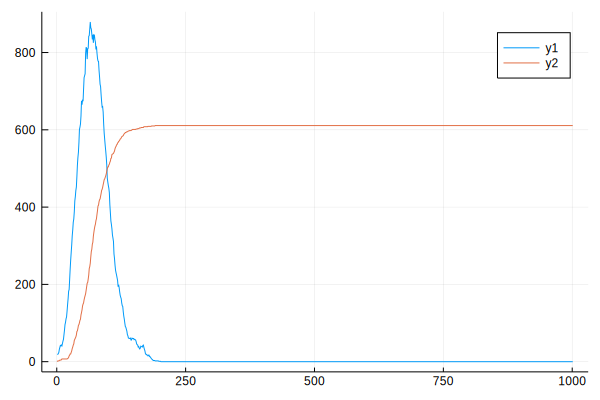

In [36]:
infected_no_travel = infected
plot([infected_no_travel, cumsum(deaths)])

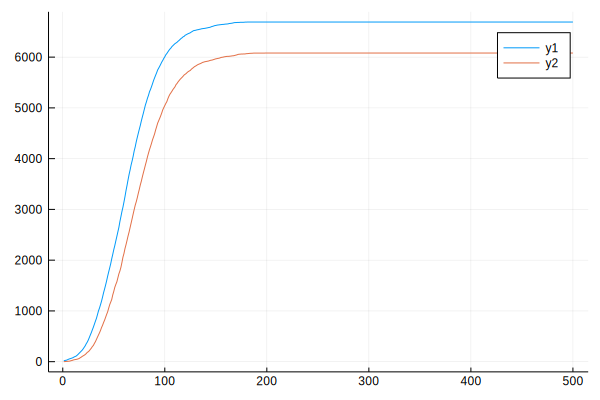

In [37]:
plot([cumsum(infections)[1:500],cumsum(survivals)[1:500]])

### B. doing the baseline

So far we have just been running tests. 
We now want to understand what the range of potential values are, and what the main drivers are.
Let's start with smaller versions of the model to reduce computation time.
We can make a couple of convenience functions to help.

In [85]:
function run_model(
        nsteps; 
        N=4, 
        total_people=10000, 
        n0=10, 
        mortrate=0.01, 
        healrate=0.1,
        r0=2,
        travel=false,
        travel_rate = 100,
        target_sparsity = 0.0,
    )
    
    if target_sparsity != 0.0
        target_d = Int(ceil((total_people / (1-target_sparsity))^(1/N)))
        candidates = (target_d - 1):(target_d + 1)

        closeness_ratios = [total_people / (1-target_sparsity) - d^N for d in candidates]
        dimension_length = candidates[argmin(closeness_ratios)]
    end
    
    if Int(ceil(total_people^(1/N)))^N >= total_people / (1 - target_sparsity)
        dimension_length = Int(ceil(total_people^(1/N)))
    end
    
    tensor = zeros(Union{Missing, Int64}, (dimension_length for _ in 1:N)...)
    average_neighbours = calculate_average_neighbours(total_people, dimension_length, N)
    
    prob_infection = r0 * (mortrate + healrate) / average_neighbours

    locs = sample(1:length(tensor),(length(tensor) - total_people), replace=false)
    tensor[locs] .= missing;

    locs = sample(1:length(tensor), n0, replace=false)
    tensor[locs] .= 1;
    
    infected = [sum(skipmissing(tensor))]
    deaths = [0]
    survivals = [0]
    infections = [sum(skipmissing(tensor))]

    for step in 1:nsteps
        tensor, ndead, nhealed = heal_or_die(tensor, mortrate, healrate)
        append!(deaths, ndead)
        append!(survivals, nhealed)
        if travel
            sm = sum(skipmissing(tensor))
            tensor = switch_places(tensor, travel_rate)
            @assert sm == sum(skipmissing(tensor))
        end
        tensor, num_infected = infect_neighbours(tensor, prob_infection)
        append!(infected, sum(skipmissing(tensor)))
        append!(infections, num_infected)
    end
    return(infected,infections,survivals,deaths)
end

run_model (generic function with 1 method)

We are going to produce our baseline model now.

In [45]:
infectedlist = []
infectionslist = []
survivalslist = []
deathslist = []

for i in 1:100
    infected,infections,survivals,deaths = run_model(350)
    append!(infectedlist, infected)
    append!(infectionslist, infections)
    append!(survivalslist, survivals)
    append!(deathslist, deaths)
end

In [46]:
infectedlist, infectionslist, survivalslist, deathslist = (convert(Array{Int64}, reshape(i, 351, 100)) for i in [infectedlist, infectionslist, survivalslist, deathslist])

Base.Generator{Array{Array{Any,1},1},var"#73#74"}(var"#73#74"(), Array{Any,1}[[10, 7, 9, 9, 10, 10, 14, 14, 12, 14  …  0, 0, 0, 0, 0, 0, 0, 0, 0, 0], [10, 1, 2, 1, 1, 1, 4, 3, 0, 4  …  0, 0, 0, 0, 0, 0, 0, 0, 0, 0], [0, 3, 0, 1, 0, 1, 0, 3, 1, 2  …  0, 0, 0, 0, 0, 0, 0, 0, 0, 0], [0, 1, 0, 0, 0, 0, 0, 0, 1, 0  …  0, 0, 0, 0, 0, 0, 0, 0, 0, 0]])

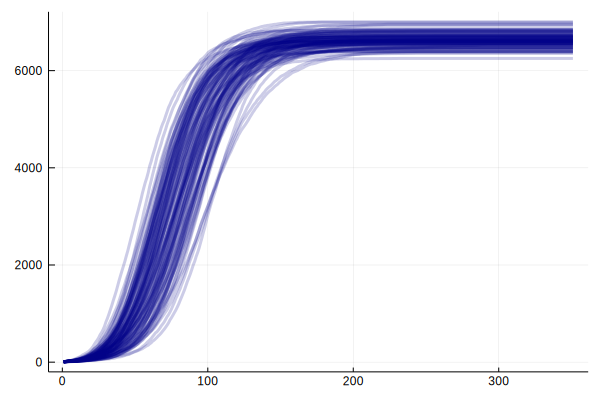

In [47]:
plot(cumsum(infectionslist, dims = 1), color="darkblue", w=3, alpha=0.2, legend = nothing)

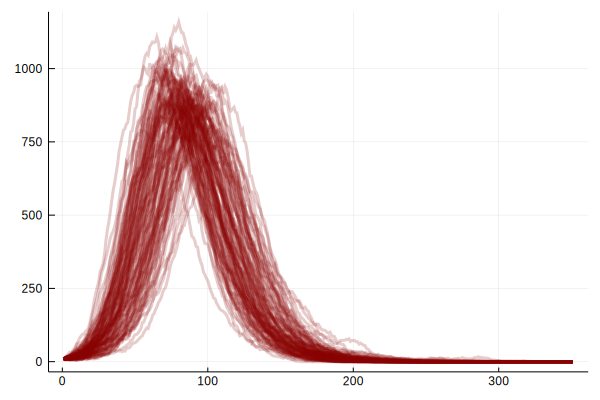

In [48]:
plot(infectedlist, color="darkred", w=3, alpha=0.2, legend=nothing)

600.7
30.018344559635697


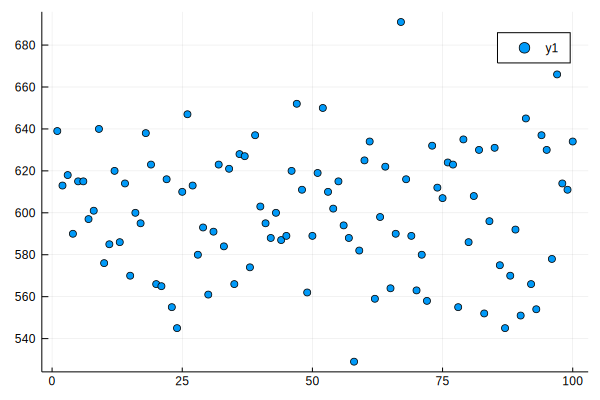

In [49]:
end_deaths = cumsum(deathslist, dims=1)[size(deathslist)[1],:]

println(mean(end_deaths))
println(std(end_deaths))
scatter(end_deaths)

6633.3
145.60334245247714


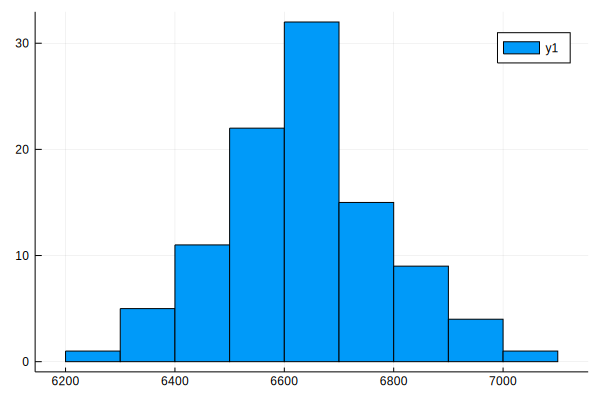

In [50]:
end_infections = cumsum(infectionslist, dims=1)[size(infectionslist)[1],:]
println(mean(end_infections))
println(std(end_infections))
histogram(end_infections)

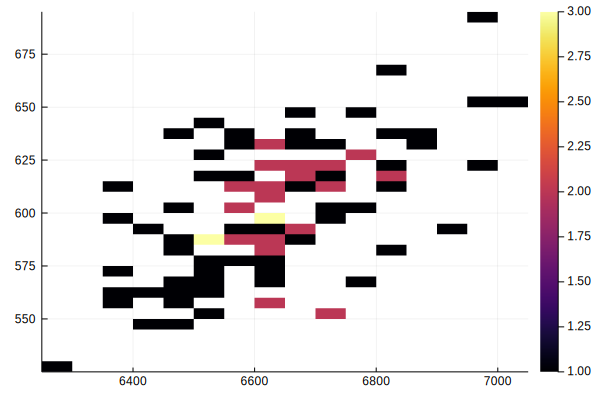

In [51]:
histogram2d(end_infections,end_deaths,nbins=30)

0.09054517811151032 +/- 0.0037592016038401066 deaths per capita


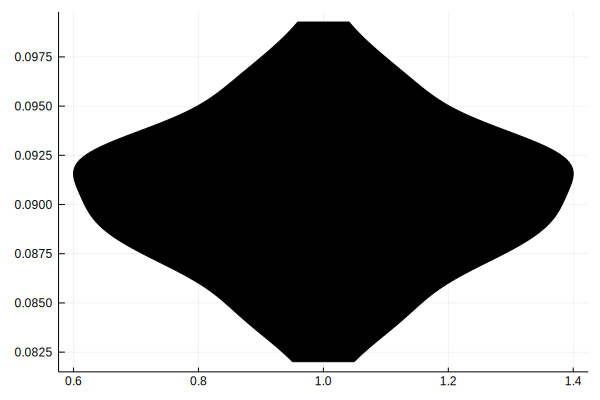

In [52]:
println(mean(end_deaths./end_infections)," +/- ", std(end_deaths./end_infections), " deaths per capita")
violin(end_deaths./end_infections, color="black", legend=nothing)

### C. exploring the parameters

#### C1. N

`N` is the number of dimensions in our hypercube. 
$3^{`N`}$ is a proxy for the estimated number of people that we might come in contact with (our "neighbours"). 
There are a couple of issues with our model.
Firstly, literal "edge cases".
The hypercube's edges curb the reproductive behaviour - there might be some fixes we can apply to this.

In [53]:
Ninfectedlist = []
Ninfectionslist = []
Nsurvivalslist = []
Ndeathslist = []

for N in [1,2,3,4,5,6,7,8,9,10]
    for i in 1:10
        infected,infections,survivals,deaths = run_model(350,N=N)
        append!(Ninfectedlist, infected)
        append!(Ninfectionslist, infections)
        append!(Nsurvivalslist, survivals)
        append!(Ndeathslist, deaths)
    end
end

Ninfectedlist, Ninfectionslist, Nsurvivalslist, Ndeathslist = (convert(Array{Int64}, reshape(i, 351, 100)) for i in [Ninfectedlist, Ninfectionslist, Nsurvivalslist, Ndeathslist]);

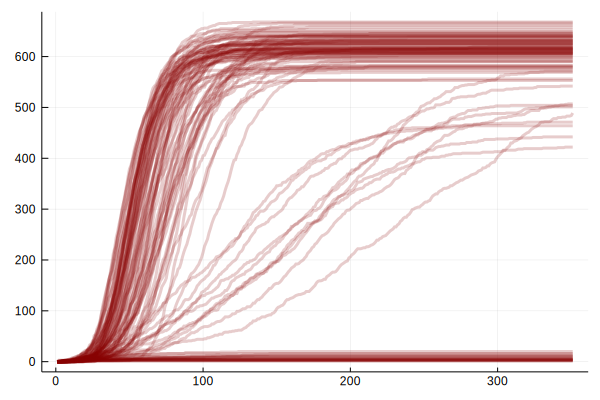

In [54]:
plot(cumsum(Ndeathslist, dims=1), color="darkred", w=3, alpha=0.2, legend=nothing)

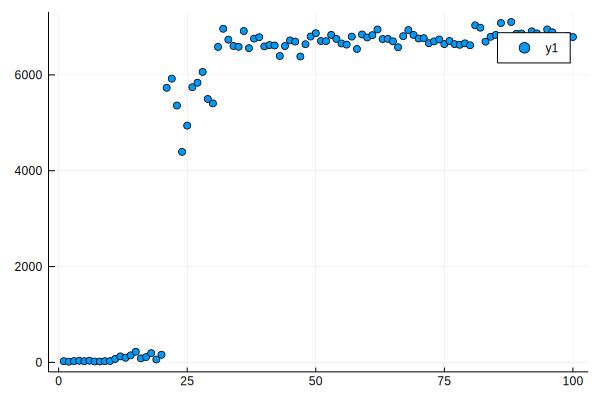

In [55]:
Nend_infections = cumsum(Ninfectionslist, dims=1)[size(Ninfectionslist)[1],:]
scatter(Nend_infections)

#### C2. `r0`

`r0` is our base rate of reproduction.
It represents the expected number of infections one infection produces if the original infection is surrounded by uninfected neighbours.
We know that if r0 is less than 1 then we will not see the infection spreading on average.

In [56]:
r0infectedlist = []
r0infectionslist = []
r0survivalslist = []
r0deathslist = []

for r0 in [0,0.5,1,1.5,2,2.5,3,3.5,4,4.5,5]
    for i in 1:10
        infected,infections,survivals,deaths = run_model(350,r0=r0)
        append!(r0infectedlist, infected)
        append!(r0infectionslist, infections)
        append!(r0survivalslist, survivals)
        append!(r0deathslist, deaths)
    end
end

In [57]:
r0infectedlist, r0infectionslist, r0survivalslist, r0deathslist = (convert(Array{Int64}, reshape(i, 351, 110)) for i in [r0infectedlist, r0infectionslist, r0survivalslist, r0deathslist]);

We can see that as r0 goes up the peak of the infected curve becomes sharper and earlier.
In the graph below the lighter reds are higher `r0` values.

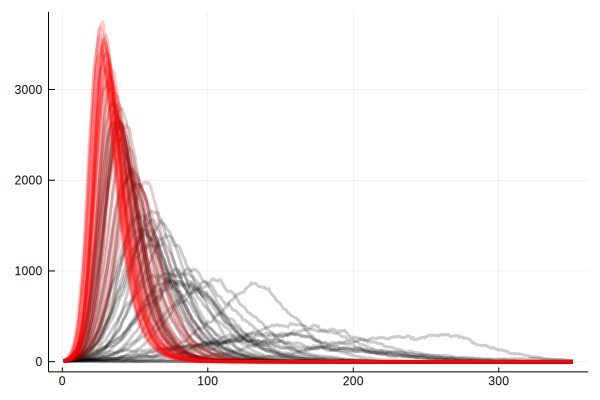

In [58]:
plot(r0infectedlist[:,31:60], color=:black, w=3, alpha=0.2, legend=nothing)
plot!(r0infectedlist[:,61:90], color=:darkred, w=3, alpha=0.2)
plot!(r0infectedlist[:,91:110], color=:red, w=3, alpha=0.2)

The total number of infections goes up as r0 goes up, it is converging towards the total_population.

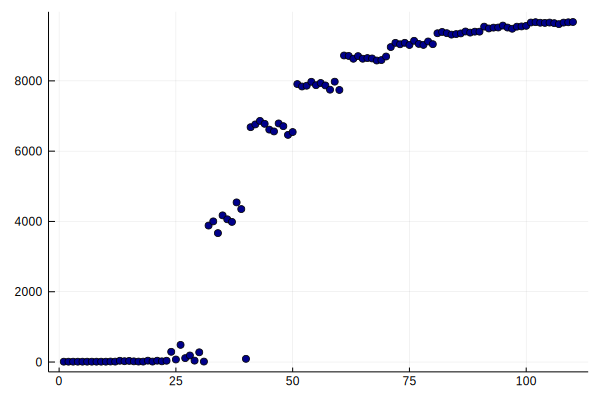

In [59]:
r0end_infections = cumsum(r0infectionslist, dims=1)[size(r0infectionslist)[1],:]
scatter(r0end_infections,legend=nothing, color="darkblue")

Total deaths follows a similar pattern, although the demarcations are less clear.

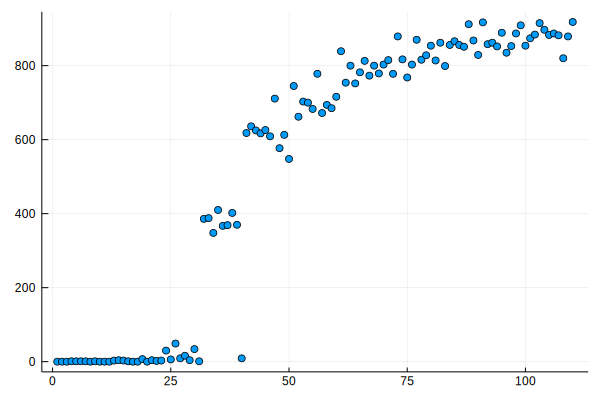

In [60]:
r0end_deaths = cumsum(r0deathslist, dims=1)[size(r0deathslist)[1],:]
scatter(r0end_deaths, legend=nothing)

The deathrate, however, is constant regardless of `r0`.

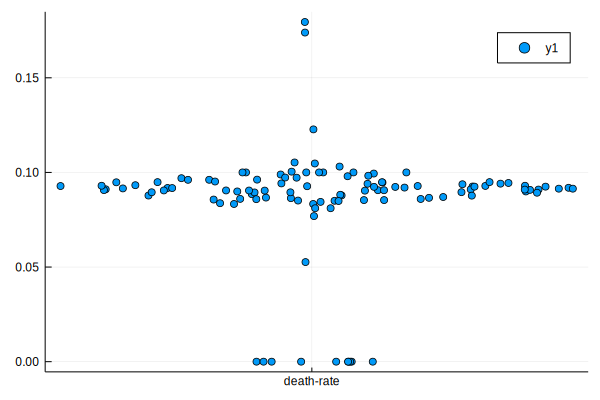

In [61]:
r0deathrates = r0end_deaths./r0end_infections
dotplot(["death-rate"],r0deathrates)

#### C3. mort and heal

Let's have a look at different mortality and healing rates.
In the following section it is important to remember that we are holding `r0` constant regardless of the mortality and healing rates.
Therefore, higher mortality and healing rates *will* lead to quicker infections.

In [62]:
values = [(mort, heal) for mort in 1 ./ (1:50) for heal in 1 ./ (1:50)]

2500-element Array{Tuple{Float64,Float64},1}:
 (1.0, 1.0)                  
 (1.0, 0.5)                  
 (1.0, 0.3333333333333333)   
 (1.0, 0.25)                 
 (1.0, 0.2)                  
 (1.0, 0.16666666666666666)  
 (1.0, 0.14285714285714285)  
 (1.0, 0.125)                
 (1.0, 0.1111111111111111)   
 (1.0, 0.1)                  
 (1.0, 0.09090909090909091)  
 (1.0, 0.08333333333333333)  
 (1.0, 0.07692307692307693)  
 ⋮                           
 (0.02, 0.02564102564102564) 
 (0.02, 0.025)               
 (0.02, 0.024390243902439025)
 (0.02, 0.023809523809523808)
 (0.02, 0.023255813953488372)
 (0.02, 0.022727272727272728)
 (0.02, 0.022222222222222223)
 (0.02, 0.021739130434782608)
 (0.02, 0.02127659574468085) 
 (0.02, 0.020833333333333332)
 (0.02, 0.02040816326530612) 
 (0.02, 0.02)                

In [63]:
# mhinfectedlist = []
# mhinfectionslist = []
# mhsurvivalslist = []
# mhdeathslist = []

# for value in values
#     infected,infections,survivals,deaths = run_model(350,mortrate=value[1],healrate=value[2])
#     append!(mhinfectedlist, infected)
#     append!(mhinfectionslist, infections)
#     append!(mhsurvivalslist, survivals)
#     append!(mhdeathslist, deaths)
# end



In [64]:
# mhinfectedlist, mhinfectionslist, mhsurvivalslist, mhdeathslist = (convert(Array{Int64}, reshape(i, 351, 2500)) for i in [mhinfectedlist, mhinfectionslist, mhsurvivalslist, mhdeathslist]);

In [65]:
# the above code took a long time so we have saved the data in relevant files.

# using DelimitedFiles;
# macro Name(arg)
#    string(arg)
# end

# e = 0
# for i in [mhinfectedlist, mhinfectionslist, mhsurvivalslist, mhdeathslist]
#     e+=1
#     open(string(e,".csv"), "w") do io
#            writedlm(io, i, ',')
#        end;
# end

In [66]:
using DelimitedFiles;

mhinfectedlist, mhinfectionslist, mhsurvivalslist, mhdeathslist =  (readdlm(string(i,".csv"),',',Int64) for i in 1:4)

Base.Generator{UnitRange{Int64},var"#83#84"}(var"#83#84"(), 1:4)

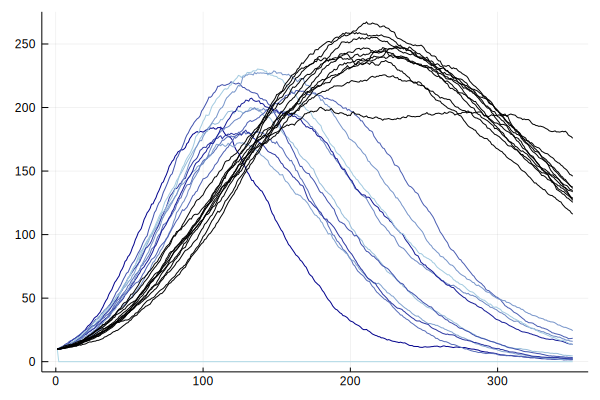

In [67]:
gr()

fig = plot(mean(mhinfectedlist[:,50*(1-1)+1:50*1], dims=2), palette=:blues, legend=nothing)

for i in 10:20
    plot!(mean(mhinfectedlist[:,50*(i-1)+1:50*i], dims=2))
end
for i in 40:50
    plot!(mean(mhinfectedlist[:,50*(i-1)+1:50*i], dims=2), color=:black)
end

fig

Above, we see that the higher mortality values (lighter blues) show steeper but smaller peaks.

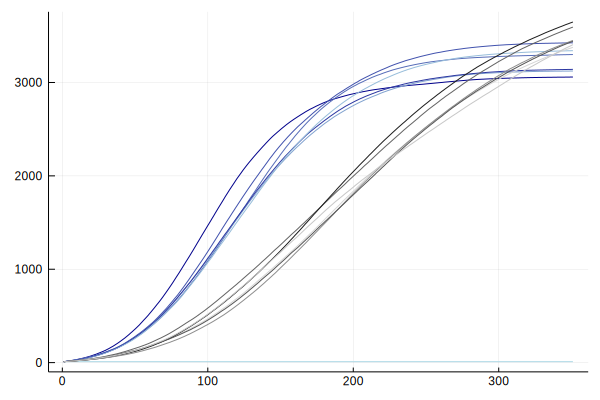

In [68]:
fig = plot(mean(cumsum(mhinfectionslist[:,50*(1-1)+1:50*1], dims=1), dims=2), palette=:blues, legend=nothing)
for i in 10:15
    plot!(mean(cumsum(mhinfectionslist[:,50*(i-1)+1:50*i], dims=1), dims=2), palette=:blues)
end
for i in 45:50
    plot!(mean(cumsum(mhinfectionslist[:,50*(i-1)+1:50*i], dims=1), dims=2), palette=:grays)
end

fig

And the total number of infections for higher mortality rates (lighter blues) is lower than for lower mortality rates (darker blues).

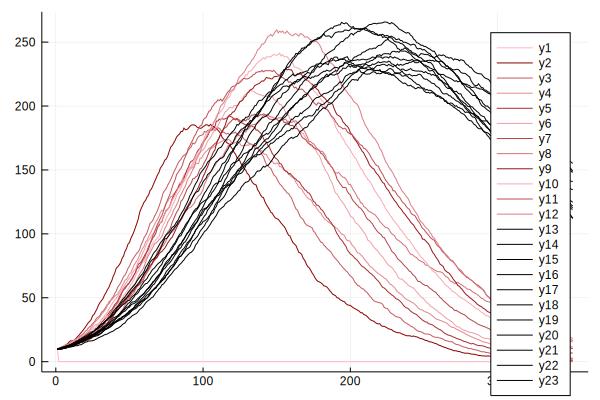

In [69]:
fig = plot(mean(mhinfectedlist[:,[(j-1)*50+1 for j in 1:50]], dims=2), palette=:reds)
for i in 10:20
    plot!(mean(mhinfectedlist[:,[(j-1)*50+i for j in 1:50]], dims=2), palette=:reds)
end
for i in 40:50
    plot!(mean(mhinfectedlist[:,[(j-1)*50+i for j in 1:50]], dims=2), color=:black)
end

fig

As expected we find the same to be true of healing rates.

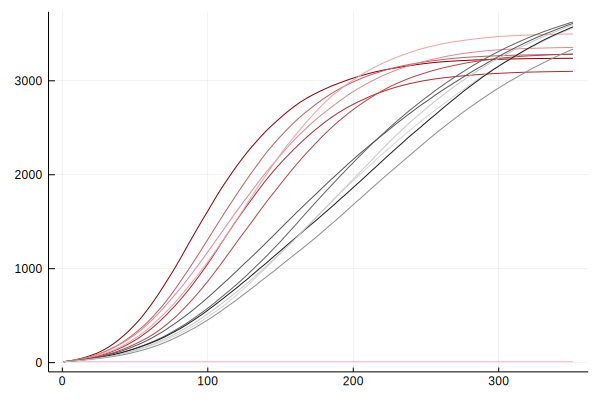

In [70]:
fig = plot(mean(cumsum(mhinfectionslist[:,[(j-1)*50+1 for j in 1:50]], dims=1), dims=2), palette=:reds, legend=nothing)
for i in 10:15
    plot!(mean(cumsum(mhinfectionslist[:,[(j-1)*50+i for j in 1:50]], dims=1), dims=2), palette=:reds)
end
for i in 45:50
    plot!(mean(cumsum(mhinfectionslist[:,[(j-1)*50+i for j in 1:50]], dims=1), dims=2), palette=:grays)
end

fig

It seems that lower mortality and healing rates both increase the total number of infections substantially, and lengthen and broaden the peak.
The total numbers of infections are higher for lower mortality and healing rates.

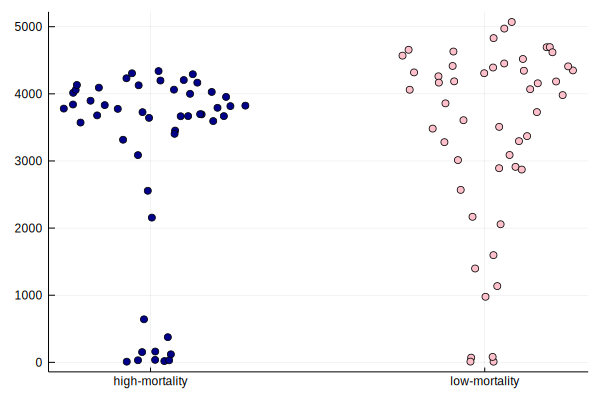

In [71]:
fig = plot(legend = nothing)
for i in 10
    dotplot!(["high-mortality"],cumsum(mhinfectionslist[:,50*(i-1)+1:50*i], dims = 1)[351,:], color =:darkblue)
end
for i in 50
    dotplot!(["low-mortality"],cumsum(mhinfectionslist[:,50*(i-1)+1:50*i], dims = 1)[351,:], color =:pink)
end
fig

The total number of infections is higher for lower mortality rates (blue) and higher healing rates.
However, the total number of infections for higher mortality rates (pink) remains more constant, and larger than the former at low healing rates.

#### C4. sparsity

In [86]:
spinfectedlist = []
spinfectionslist = []
spsurvivalslist = []
spdeathslist = []

for sp in range(0,0.9,step=0.1)
    for i in 1:10
        infected,infections,survivals,deaths = run_model(350,target_sparsity=sp)
        append!(spinfectedlist, infected)
        append!(spinfectionslist, infections)
        append!(spsurvivalslist, survivals)
        append!(spdeathslist, deaths)
    end
end

In [87]:
spinfectedlist, spinfectionslist, spsurvivalslist, spdeathslist = (convert(Array{Int64}, reshape(i, 351, 100)) for i in [spinfectedlist, spinfectionslist, spsurvivalslist, spdeathslist]);

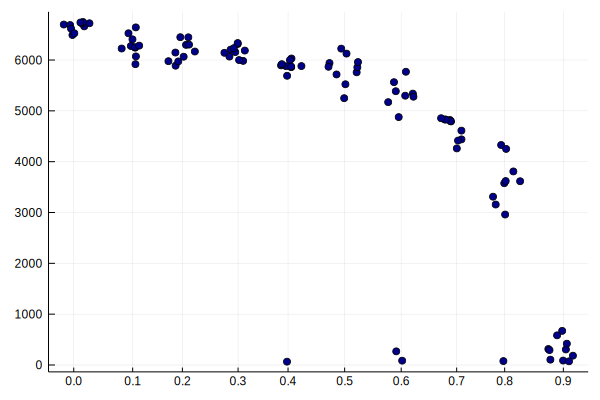

In [100]:
fig = dotplot(legend=nothing)
for i in 1:10
    dotplot!(["$(round(i/10 - 0.1,digits=1))"],cumsum(spinfectionslist,dims=1)[351, ((i-1)*10+1):i*10],color=:darkblue)
end
fig

### D. travel

Our first actual statistical question is whether travelling appears to make matters worse or not.

In [255]:
function switch_places(array, n)
    locs = sample(1:length(array), n, replace=false)
    value_first = array[locs[1]]
    for i in 1:(length(locs) - 1)
        array[locs[i]] = array[locs[i+1]]
    end
    array[locs[end]] = value_first
    return array
end

switch_places (generic function with 1 method)

In [256]:
trinfectedlist = []
trinfectionslist = []
trsurvivalslist = []
trdeathslist = []

for travel in [true, false]
    for i in 1:100

        infected,infections,survivals,deaths = run_model(350,travel=travel)
        append!(trinfectedlist, infected)
        append!(trinfectionslist, infections)
        append!(trsurvivalslist, survivals)
        append!(trdeathslist, deaths)
        
    end
end

In [257]:
trinfectedlist, trinfectionslist, trsurvivalslist, trdeathslist = (convert(Array{Int64}, reshape(i, 351, 200)) for i in [trinfectedlist, trinfectionslist, trsurvivalslist, trdeathslist]);

In [258]:
tr100infectionslist = deepcopy(trinfectionslist)
tr100infectedlist = deepcopy(trinfectedlist);
tr100survivalslist = deepcopy(trsurvivalslist);
tr100deathslist = deepcopy(trdeathslist);

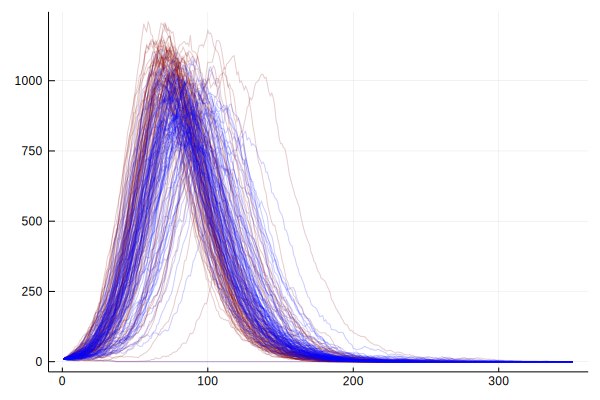

In [259]:
plot(tr100infectedlist[:,1:100], alpha=0.2, color=:darkred, legend=nothing)
plot!(tr100infectedlist[:,101:200], alpha = 0.2, color=:blue)

With travel in red, without travel in blue.

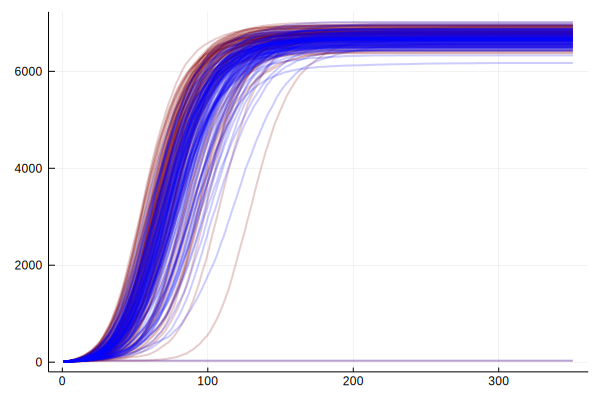

In [260]:
plot(cumsum(tr100infectionslist[:,1:100], dims=1), w=2, alpha=0.2, color=:darkred, legend=nothing)
plot!(cumsum(tr100infectionslist[:,101:200], dims=1), w=2, alpha=0.2, color=:blue)

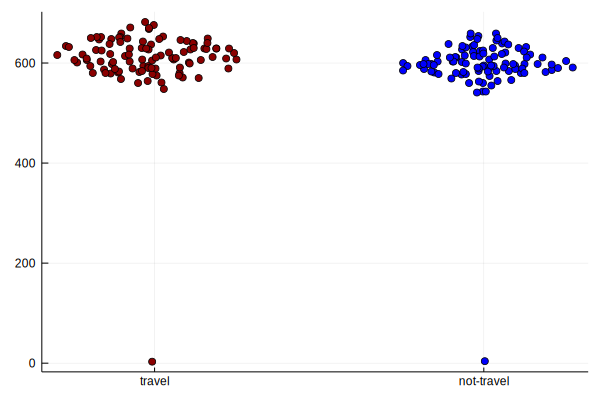

In [261]:
dotplot(["travel"],cumsum(tr100deathslist[:,1:100], dims=1)[351,:], color=:darkred, legend=nothing)
dotplot!(["not-travel"],cumsum(tr100deathslist[:,101:200], dims=1)[351,:], color=:blue)

From the above graphs we can see that travelling has the potential to either make things much worse or much better than not-travelling.
We presume that parts of this are to do with islanding effects.
We should see what happens as the number of people travelling each day increases.

In [262]:
trinfectionslist = []
trinfectedlist = []
trsurvivalslist = []
trdeathslist = []

for travel_rate in [1,10,1000,5000,10000]
    for i in 1:50
        infected,infections,survivals,deaths = run_model(350, travel=true, travel_rate=travel_rate)
        append!(trinfectedlist, infected)
        append!(trinfectionslist, infections)
        append!(trsurvivalslist, survivals)
        append!(trdeathslist, deaths)
    end
end

trinfectedlist, trinfectionslist, trsurvivalslist, trdeathslist = (convert(Array{Int64}, reshape(i, 351, 250)) for i in [trinfectedlist, trinfectionslist, trsurvivalslist, trdeathslist]);

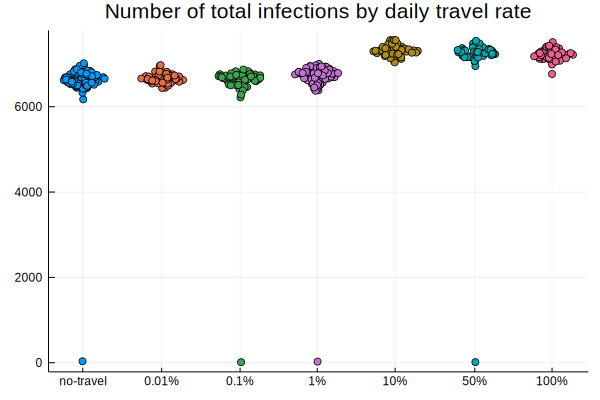

In [263]:
dotplot(["no-travel"], cumsum(tr100infectionslist[:,101:200], dims=1)[351,:],legend=nothing, title="Number of total infections by daily travel rate")
dotplot!(["0.01%"],cumsum(trinfectionslist, dims=1)[351,1:50])
dotplot!(["0.1%"], cumsum(trinfectionslist, dims=1)[351, 51:100])
dotplot!(["1%"], cumsum(tr100infectionslist[:,1:100], dims=1)[351,:])
dotplot!(["10%"], cumsum(trinfectionslist, dims=1)[351, 101:150])
dotplot!(["50%"], cumsum(trinfectionslist, dims=1)[351,151:200])
dotplot!(["100%"], cumsum(trinfectionslist, dims=1)[351, 201:250])


You can see that as the travel rate is increase, the distribution of the total infections is drawn higher.
At 10% of the population moving around on a daily basis the total infections is 50% of the total population.
Even at 1% of the population moving around daily the effect is evident.

### Z. appendix

#### Z1. average number of neighbours

The average number of neighbours calculation comes from our need to match our R0 to something meaningful.
The issue with just dividing the number of people by the number of total cells is that we have literal edge cases.
We need to account for the edginess of our hypercubes.

The maths is relatively straightforward but takes a bit of thinking about to get an intuition.
On a straight line you have `dimension_length` people.
There are two ends to your straight line.
Everyone in the middle of your straight line has $3 ^ N - 1$ neighbours.
The people at the end of the straight line have $3 ^{N - 1} \times 2 ^ N - 1$ neighbours.

Likewise on a square you have `dimension_length`$^{N}$ cells.
There are four corners to your square, four edges to your square, and the middle area.
Everyone in the middle has $3^N - 1$ neighbours.
Everyone on the edges has $3^{N-1} \times 2 ^ 1 - 1$ neighbours.
The four corners each have $3^{N-2} \times 2 ^ 2 - 1$ neighbours.
You can draw this out to confirm!

How many of each type are there?
Well, there's $($ `dimension_length` $-2)^N$ people in the middle.
There's $2^{N-1} \times {2 \choose 1} \times$ `dimension_length`$^{2-1} = 4$ people on the edges.
There's $2^{N} \times {2 \choose 0} = 4$ people on the edges.

You can think similarly for the n-dimensional case.
With each corner/edge/face you're choosing you're essentially selecting a lower-dimensional $n$-cube from the larger $N$-cube.
As each vertex has $N$ lines leading to it you can make $N \choose n$ $n$-cubes from the $N$ cube. Then we must factor in the length of our sides.

Our final formula for the average neighbours is:
$$\begin{align}
\text{average number of neighbours for cell in N-cube} &= \dfrac{\sum_{n = 0}^N \text{number of n-cubes} \times \text{number of neighbours of n-cube in N-cube}}{\text{dimension_length}^N} \\\\
&= \dfrac{\sum_{n = 0}^N [2^{N-n} \times {N \choose n} \times (\text{dimension_length}-2)^n] \times [3^n \times 2^{N-n} -1]}{{\text{dimension_length}^N}}
\end{align}$$

length of one dimension = 3.0
total number of cells = 59049.0
("number_of_n-cells = ", "number_of_neighbours = ")
(1024.0, 1023)
(5120.0, 1535)
(11520.0, 2303)
(15360.0, 3455)
(13440.0, 5183)
(8064.0, 7775)
(3360.0, 11663)
(960.0, 17495)
(180.0, 26243)
(20.0, 39365)
(1.0, 59048)
average_neighbours = 809.9617513460363


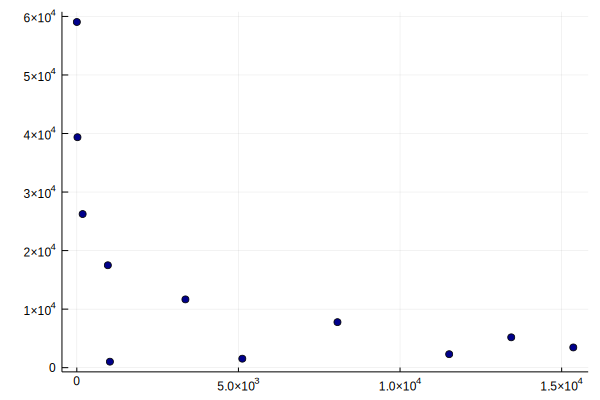

In [186]:
N = 10
total_people = 10000
dimension_length = ceil(total_people^(1/N))
println("length of one dimension = ", dimension_length)
println("total number of cells = ", dimension_length^N)
println(("number_of_n-cells = ", "number_of_neighbours = "))
fig = scatter(legend=nothing)
for tuple in ([(2^(N-n) * binomial(N, n) * (dimension_length-2)^(n), (3^n) * 2^(N-n) - 1) for n in 0:N])
    println(tuple)
    scatter!(tuple, color=:darkblue)
end
println("average_neighbours = ", total_people / (dimension_length ^ N) * sum([2^(N-n) * binomial(N, n) * (dimension_length-2)^(n) * ((3^n) * 2^(N-n) - 1) for n in 0:N])/dimension_length^N)
fig

In [ ]:
mortrate = 0.01
healrate = 0.1
total_people = 10000
N = 5

neighbours = []
for N in 1:10
    for i in 1:10
        ###MAKE TENSOR
        tensor = zeros(Union{Missing, Int64}, (Int(ceil(total_people^(1/N))) for i in 1:N)...)
        prob_infection = r0 * (mortrate + healrate) / ((3^N - 1) * total_people / length(tensor))
        locs = sample(1:((Int(ceil(total_people^(1/N))))^N),((Int(ceil(total_people^(1/N))))^N - total_people), replace=false)
        tensor[locs] .= missing;

        n0 = 10
        locs = sample(1:length(tensor), n0, replace=false)
        tensor[locs] .= 1;

        ###For each cell find number of non-missing neighbours
        number_of_neighbours = []
        for ncube in findall(coalesce.(tensor, -1) .>= 0)
            append!(number_of_neighbours, count(coalesce.(get_neighbours(tensor, ncube), -1) .>= 0) - 1)
        end
        append!(neighbours, number_of_neighbours)
    end
end

for N in 1:10
    println("Expected number of neighbours for ",N," dimensions:")
    println((3^N-1) * 10000 / (ceil(total_people^(1/N)))^N)
    println("Estimated number of neighbours for ",N, " dimensions:")
    println(mean(neighbours[((N-1)*100000+1):(N*100000)]))
end

scatter([((3^N-1) * 10000 / (ceil(total_people^(1/N)))^N) for N in 1:10], [mean(neighbours[((N-1)*100000+1):(N*100000)]) for N in 1:10])